In [1]:
# Load required libraries
library(tidyverse)
library(janitor)
library(dplyr)
library(ggplot2)
library(skimr)
library(purrr)
library(lubridate)

# Source helper scripts
source("../../R/apply_factors.R")
source("../../R/analysis_helpers.R")
source("../../R/temporal_helpers.R")

# Load data
tables <- list(
  Orders  = readr::read_csv("../../data/processed/Orders.csv"),
  Returns = readr::read_csv("../../data/processed/Returns.csv"),
  People  = readr::read_csv("../../data/processed/People.csv")
)

# Apply factor transformations
tables <- apply_factors(tables)

# Extract tables
orders  <- tables$Orders
returns <- tables$Returns
people  <- tables$People

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.6
✔ forcats   1.0.1     ✔ stringr   1.6.0
✔ ggplot2   4.0.1     ✔ tibble    3.3.0
✔ lubridate 1.9.4     ✔ tidyr     1.3.1
✔ purrr     1.2.0     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Attaching package: ‘janitor’


The following objects are masked from ‘package:stats’:

    chisq.test, fisher.test


Rows: 51290 Columns: 21
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (13): order_id, ship_mode, customer_name, segment, state, country, mark...
dbl   (6): sales, quantity, discount, profit, shipping_cost, year
date  (2): order_date, ship_date

ℹ Use `spec()` to retrieve the full column specification f

# Executive Snapshot 

### Overall return rate (single bar / KPI)

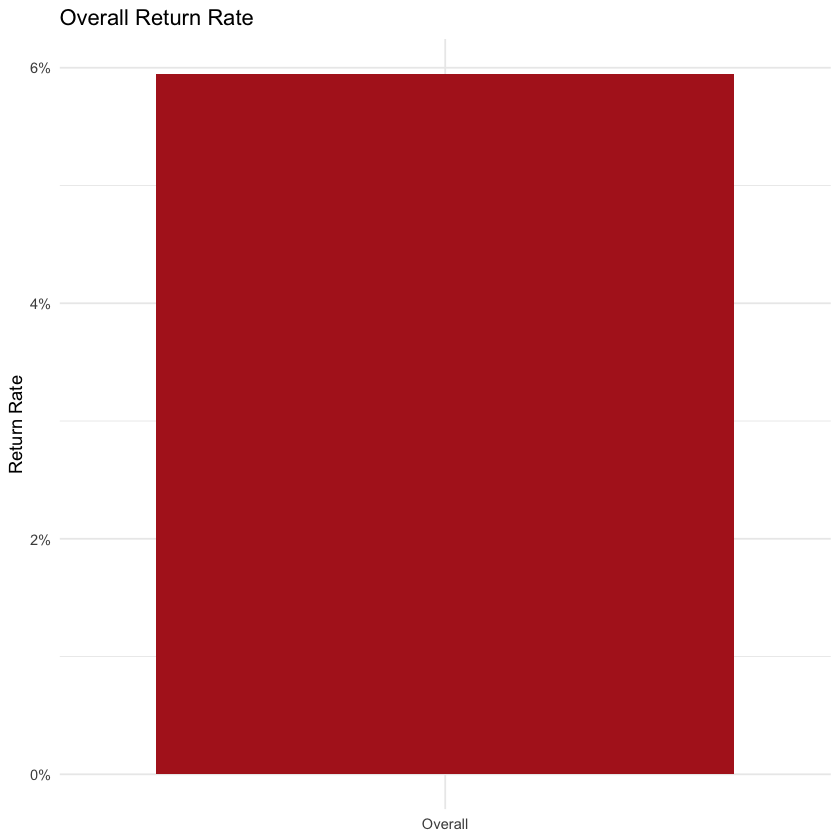

In [3]:
orders_with_returns <- orders |> 
    left_join(
        returns |> distinct(order_id) |> mutate(returned = 1),
        by = "order_id"
    ) |> 
    mutate(returned = if_else(is.na(returned), 0, returned))

orders_with_returns |> 
    summarise(return_rate = mean(returned)) |> 
    ggplot(aes(x = "Overall", y = return_rate)) + 
    geom_col(fill = "firebrick") + 
    scale_y_continuous(labels = scales::percent) + 
    labs(
        title = "Overall Return Rate",
        x = NULL,
        y = "Return Rate"
    ) + 
    theme_minimal()

### Total profit vs total returns impact (bar or paired bars)

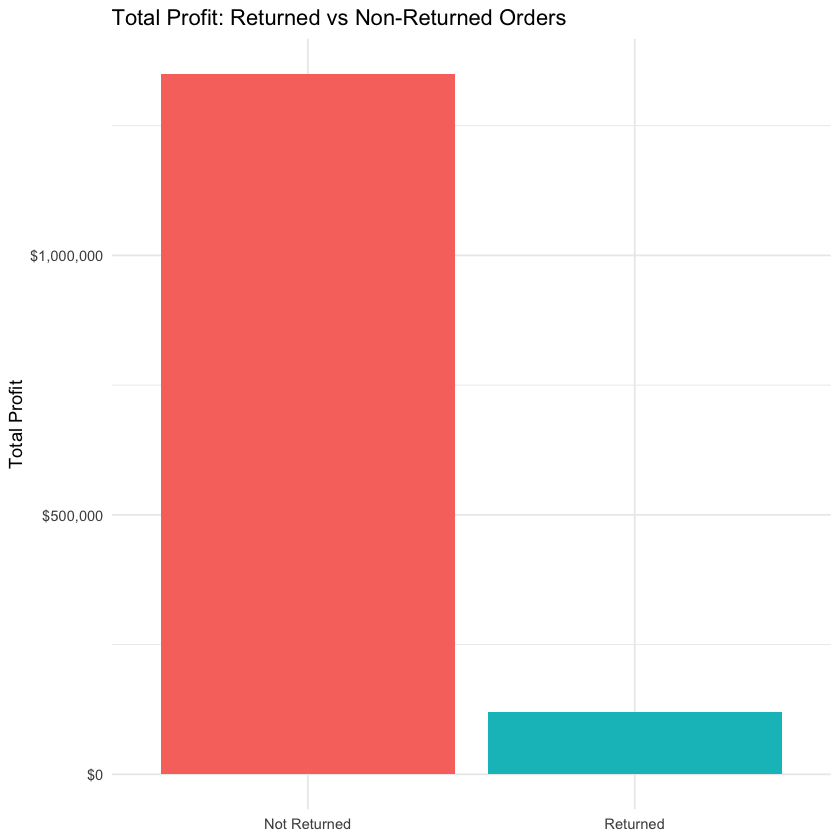

In [4]:
orders_with_returns |> 
    group_by(returned) |> 
    summarise(total_profit = sum(profit)) |> 
    mutate(status = if_else(returned == 1, "Returned", "Not Returned")) |> 
    ggplot(aes(status, total_profit, fill = status)) + 
    geom_col() + 
    scale_y_continuous(labels = scales::dollar_format()) + 
    labs(
        title = "Total Profit: Returned vs Non-Returned Orders", 
        x = NULL, 
        y = "Total Profit"
    ) + 
    theme_minimal() + 
    theme(legend.position = "none")

# Return Rates by Core Dimensions

### Return rate by Segment

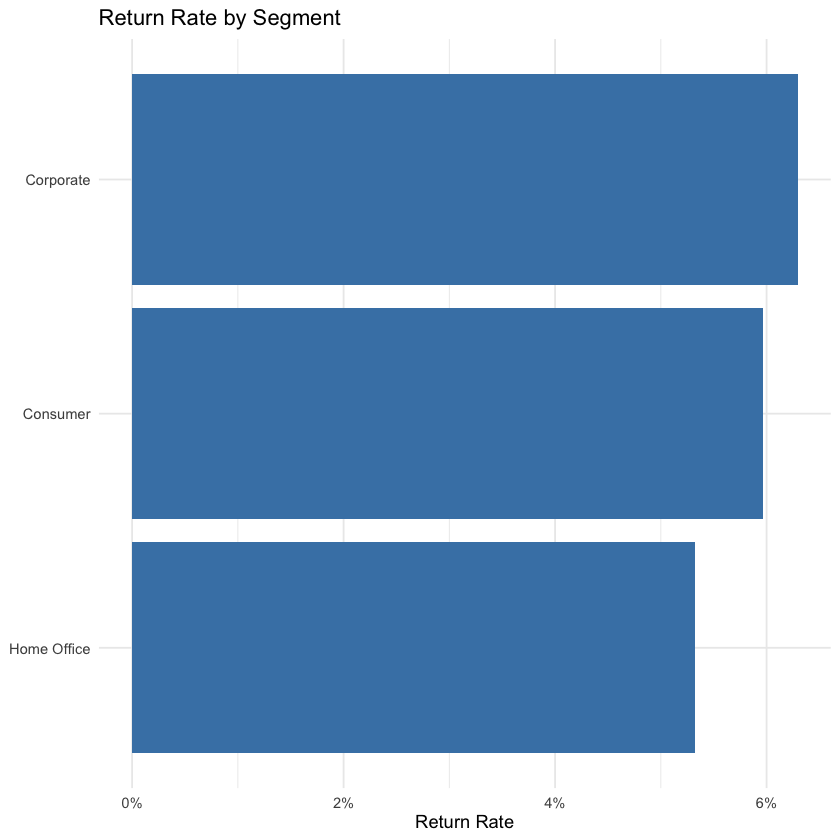

In [5]:
orders_with_returns |>  
    group_by(segment) |>  
    summarise(return_rate = mean(returned)) |>  
    ggplot(aes(reorder(segment, return_rate), return_rate)) +  
    geom_col(fill = "steelblue") +  
    coord_flip() +  
    scale_y_continuous(labels = scales::percent) +  
    labs(
        title = "Return Rate by Segment", 
        x = NULL, 
        y = "Return Rate"
    ) +  
    theme_minimal()

### Return rate by Category

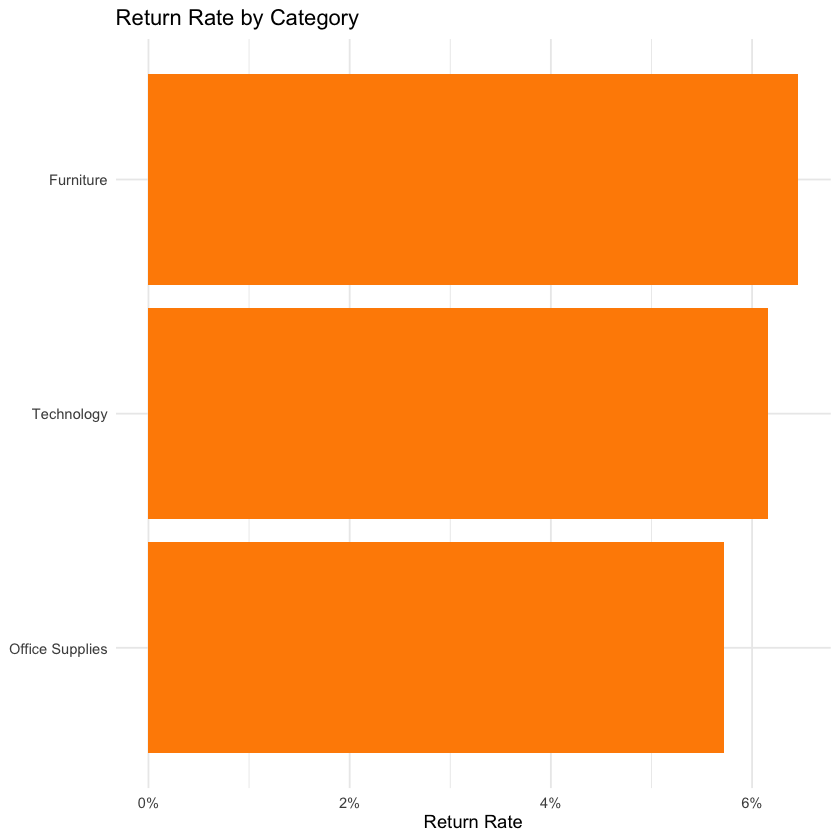

In [6]:
orders_with_returns |>  
    group_by(category) |>  
    summarise(return_rate = mean(returned)) |>  
    ggplot(aes(reorder(category, return_rate), return_rate)) +  
    geom_col(fill = "darkorange") +  
    coord_flip() +  
    scale_y_continuous(labels = scales::percent) +  
    labs(
        title = "Return Rate by Category", 
        x = NULL, 
        y = "Return Rate"
    ) +  
    theme_minimal()

### Return rate by Region

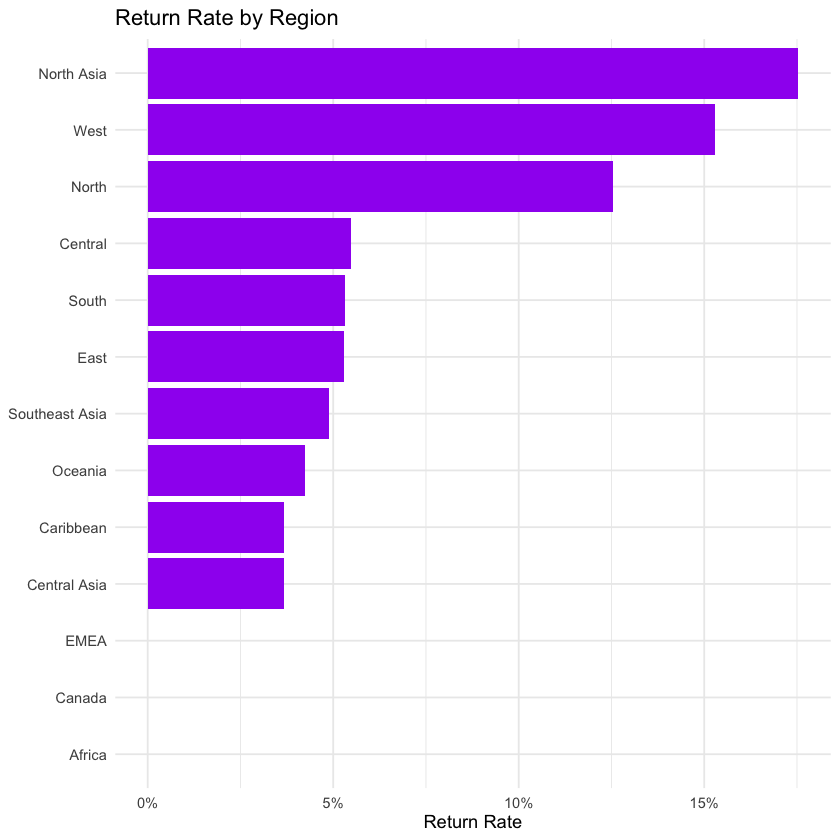

In [7]:
orders_with_returns |>  
    group_by(region) |>  
    summarise(return_rate = mean(returned)) |>  
    ggplot(aes(reorder(region, return_rate), return_rate)) +  
    geom_col(fill = "purple") +  
    coord_flip() +  
    scale_y_continuous(labels = scales::percent) +  
    labs(
        title = "Return Rate by Region", 
        x = NULL, 
        y = "Return Rate"
    ) +  
    theme_minimal()

### Return rate by Market

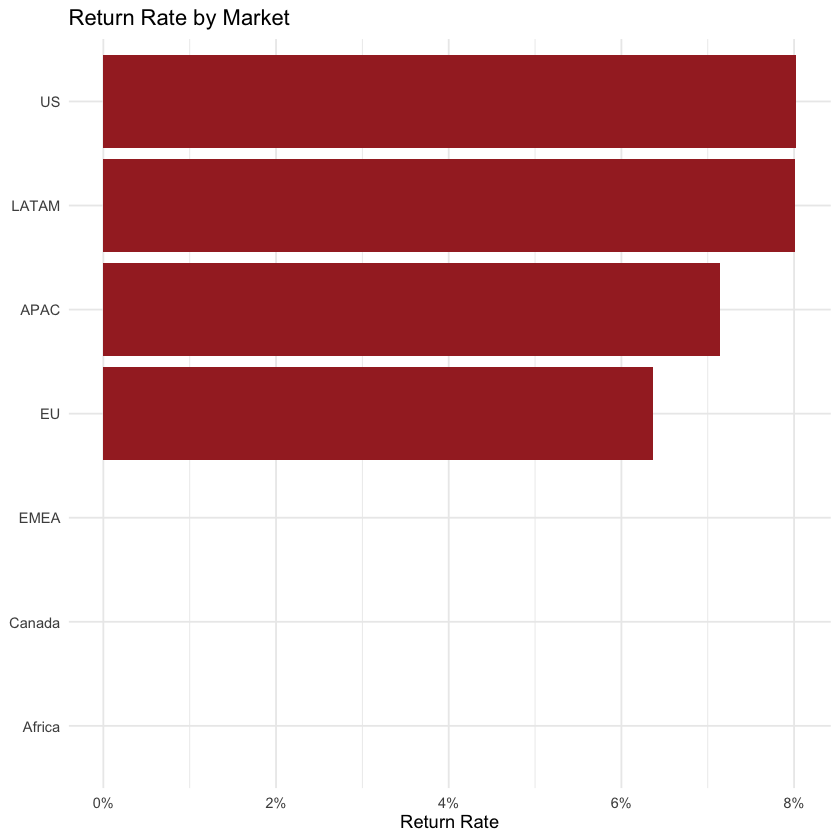

In [8]:
orders_with_returns |>  
    group_by(market) |>  
    summarise(return_rate = mean(returned)) |>  
    ggplot(aes(reorder(market, return_rate), return_rate)) +  
    geom_col(fill = "brown") +  
    coord_flip() +  
    scale_y_continuous(labels = scales::percent) +  
    labs(
        title = "Return Rate by Market", 
        x = NULL, 
        y = "Return Rate"
    ) +  
    theme_minimal()

# Return Impact on Profit

### Profit with returns vs profit without returns (bar)

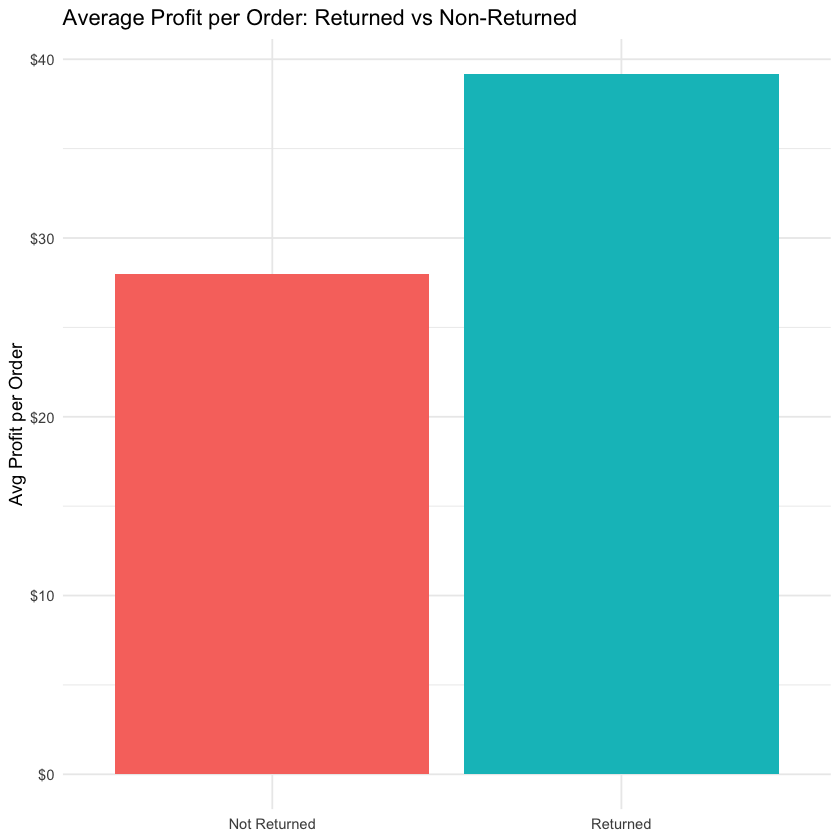

In [9]:
orders_with_returns |>  
    group_by(returned) |>  
    summarise(avg_profit = mean(profit)) |>  
    mutate(status = if_else(returned == 1, "Returned", "Not Returned")) |>  
    ggplot(aes(status, avg_profit, fill = status)) +  
    geom_col() +  
    scale_y_continuous(labels = scales::dollar_format()) +  
    labs(
        title = "Average Profit per Order: Returned vs Non-Returned", 
        x = NULL, 
        y = "Avg Profit per Order"
    ) +  
    theme_minimal() +  
    theme(legend.position = "none")

### Avg profit per order: returned vs non-returned

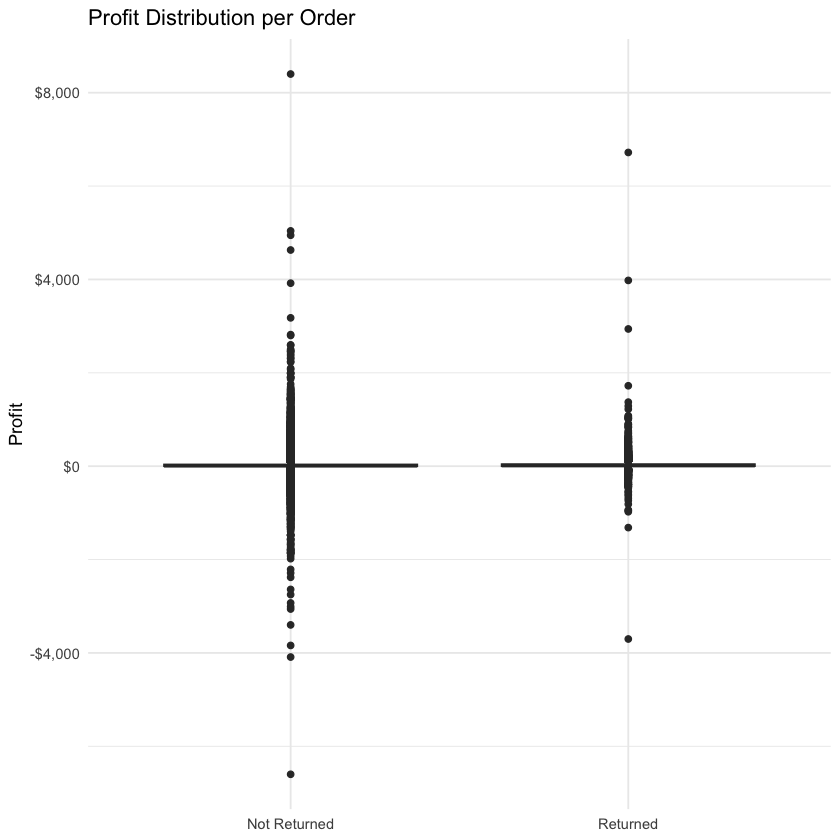

In [10]:
orders_with_returns |>  
    mutate(status = if_else(returned == 1, "Returned", "Not Returned")) |>  
    ggplot(aes(status, profit)) +  
    geom_boxplot() +  
    scale_y_continuous(labels = scales::dollar_format()) +  
    labs(
        title = "Profit Distribution per Order", 
        x = NULL, 
        y = "Profit"
    ) +  
    theme_minimal()

# Product-Level Return Concentration (Risk Focus)

### Top X% of products → % of total returns (pareto)

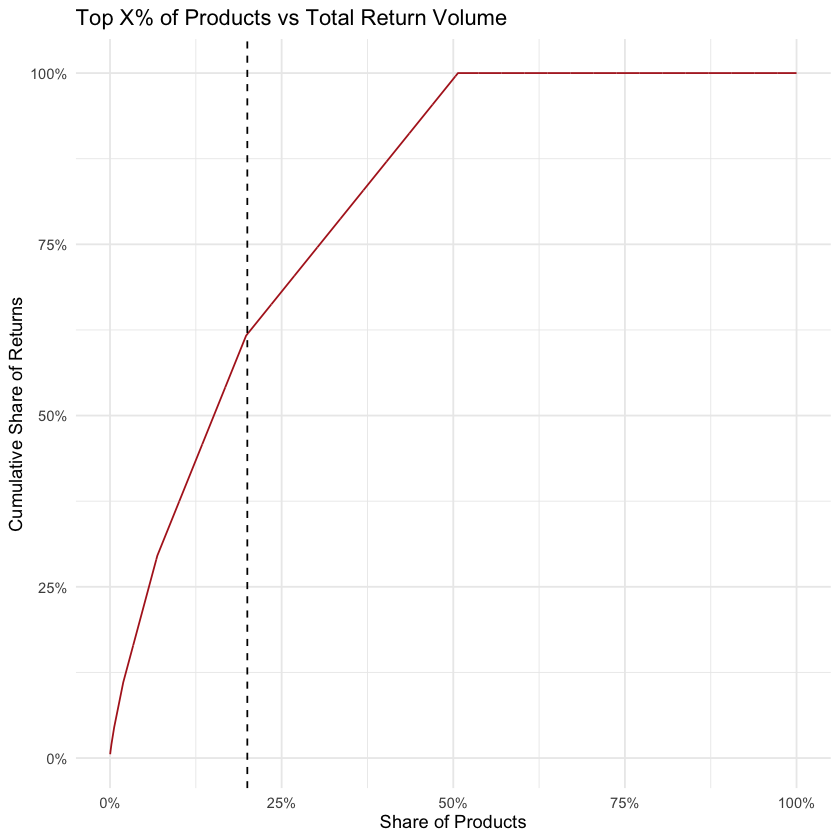

In [11]:
X <- 0.2

product_returns <- orders_with_returns |>  
    group_by(product_name) |>  
    summarise(total_returns = sum(returned)) |>  
    arrange(desc(total_returns)) |>  
    mutate(
        cum_returns = cumsum(total_returns),
        total_returns_all = sum(total_returns),
        cum_share = cum_returns / total_returns_all,
        product_pct = row_number() / n()
    )

ggplot(product_returns, aes(product_pct, cum_share)) +  
    geom_line(color = "firebrick") +  
    geom_vline(xintercept = X, linetype = "dashed") +  
    scale_x_continuous(labels = scales::percent) +  
    scale_y_continuous(labels = scales::percent) +  
    labs(
        title = "Top X% of Products vs Total Return Volume",
        x = "Share of Products",
        y = "Cumulative Share of Returns"
    ) +  
    theme_minimal()

### Return rate vs product margin (scatter)

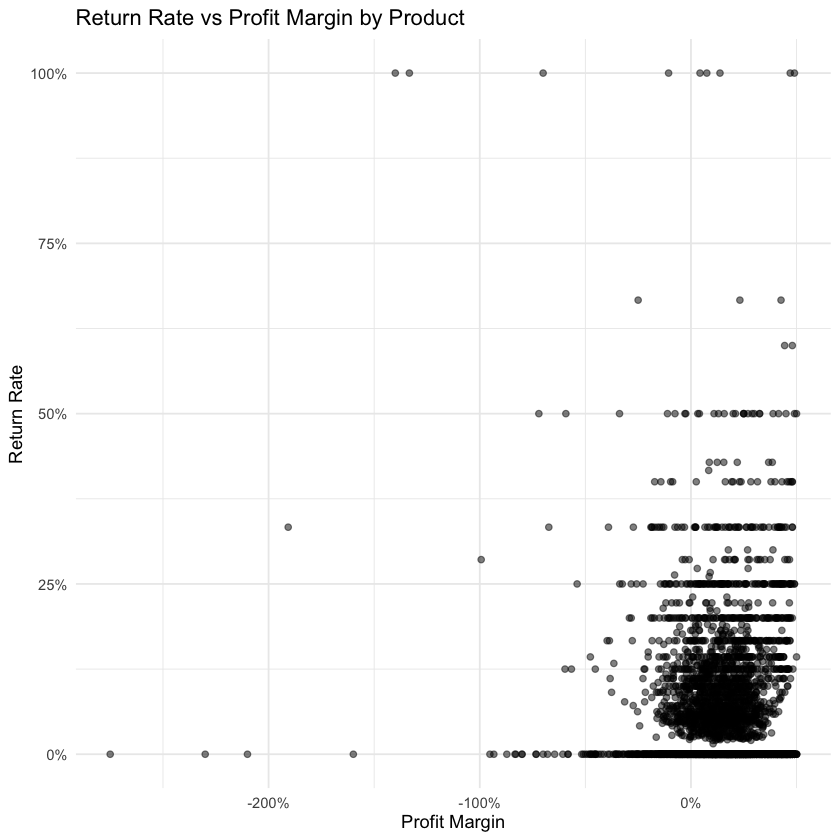

In [13]:
product_metrics <- orders_with_returns |>  
    group_by(product_name) |>  
    summarise(
        return_rate = mean(returned),
        margin = sum(profit) / sum(sales)
    )

ggplot(product_metrics, aes(margin, return_rate)) +  
    geom_point(alpha = 0.5) +  
    scale_x_continuous(labels = scales::percent) +  
    scale_y_continuous(labels = scales::percent) +  
    labs(
        title = "Return Rate vs Profit Margin by Product",
        x = "Profit Margin",
        y = "Return Rate"
    ) +  
    theme_minimal()

# Discount → Return Risk

### Discount vs Return Probability (binned line or scatter + smooth)

`geom_smooth()` using formula = 'y ~ x'


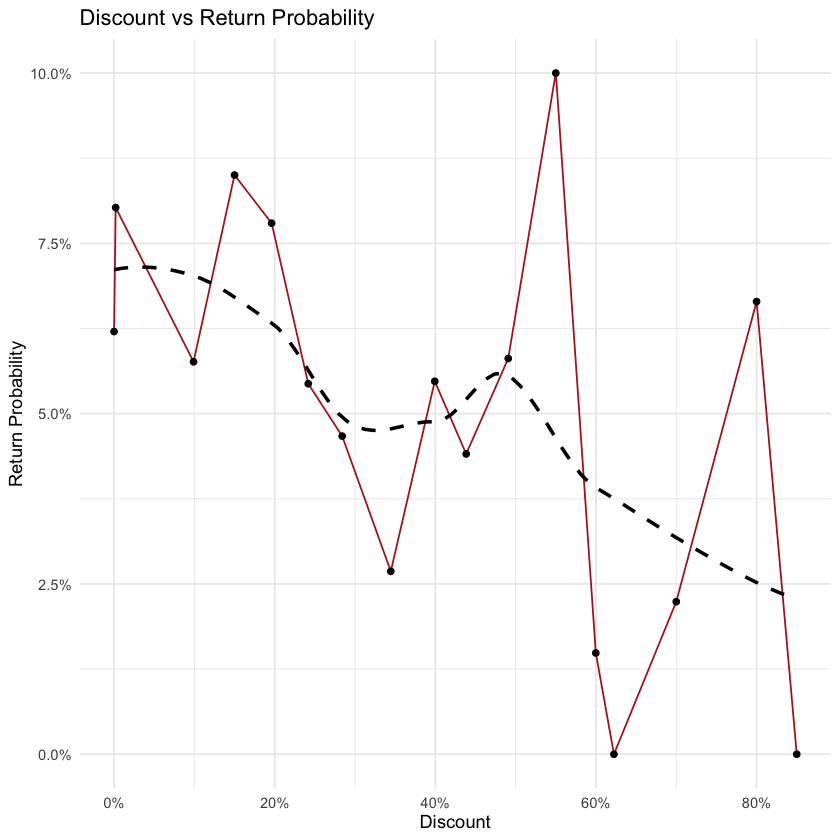

In [14]:
orders_with_returns |>  
    mutate(discount_bin = cut(discount, breaks = seq(0, 1, by = 0.05))) |>  
    group_by(discount_bin) |>  
    summarise(
        avg_discount = mean(discount), 
        return_rate = mean(returned)
    ) |>  
    ggplot(aes(avg_discount, return_rate)) +  
    geom_line(color = "firebrick") +  
    geom_point() +  
    geom_smooth(se = FALSE, method = "loess", color = "black", linetype = "dashed") +  
    scale_x_continuous(labels = scales::percent) +  
    scale_y_continuous(labels = scales::percent) +  
    labs(
        title = "Discount vs Return Probability", 
        x = "Discount", 
        y = "Return Probability"
    ) +  
    theme_minimal()

### Average discount: returned vs non-returned orders

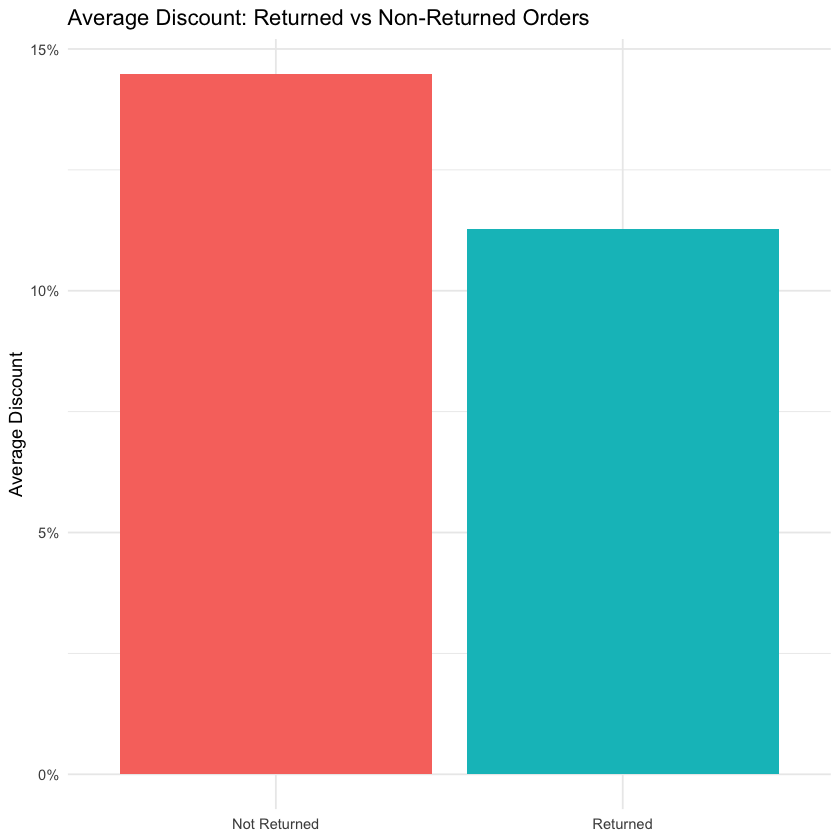

In [15]:
orders_with_returns |>  
    mutate(status = if_else(returned == 1, "Returned", "Not Returned")) |>  
    group_by(status) |>  
    summarise(avg_discount = mean(discount)) |>  
    ggplot(aes(status, avg_discount, fill = status)) +  
    geom_col() +  
    scale_y_continuous(labels = scales::percent) +  
    labs(
        title = "Average Discount: Returned vs Non-Returned Orders", 
        x = NULL, 
        y = "Average Discount"
    ) +  
    theme_minimal() +  
    theme(legend.position = "none")

### Return rate by discount bucket

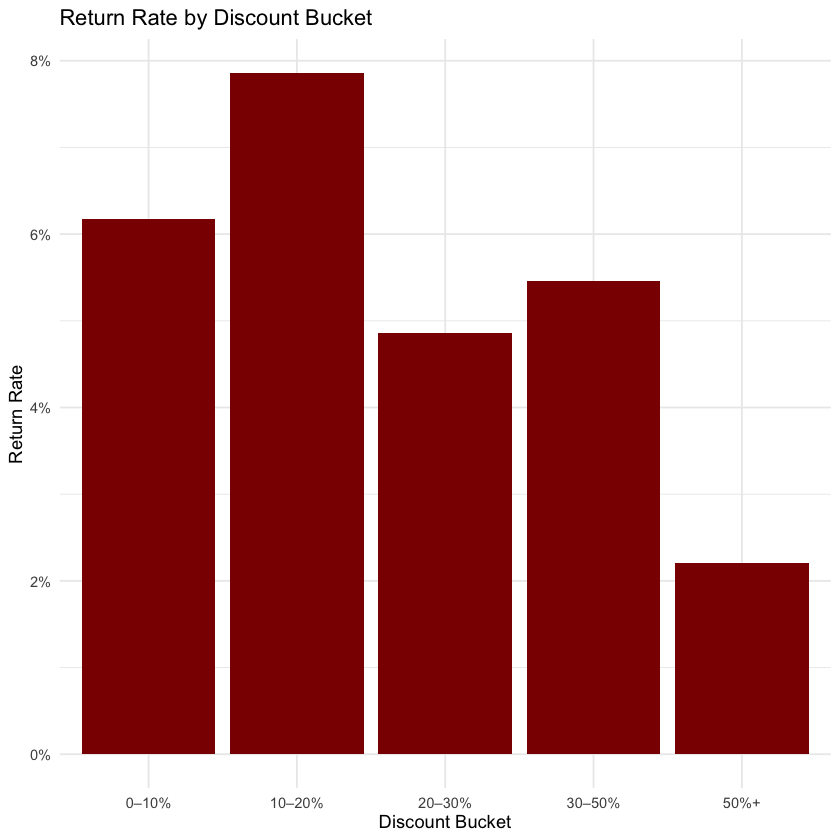

In [16]:
orders_with_returns |>  
    mutate(discount_bucket = cut(discount, breaks = c(0, 0.1, 0.2, 0.3, 0.5, 1), include.lowest = TRUE, labels = c("0–10%", "10–20%", "20–30%", "30–50%", "50%+"))) |>  
    group_by(discount_bucket) |>  
    summarise(return_rate = mean(returned)) |>  
    ggplot(aes(discount_bucket, return_rate)) +  
    geom_col(fill = "darkred") +  
    scale_y_continuous(labels = scales::percent) +  
    labs(
        title = "Return Rate by Discount Bucket", 
        x = "Discount Bucket", 
        y = "Return Rate"
    ) +  
    theme_minimal()

# Profit Impact of Discounts

### Profit per order: discount vs no discount

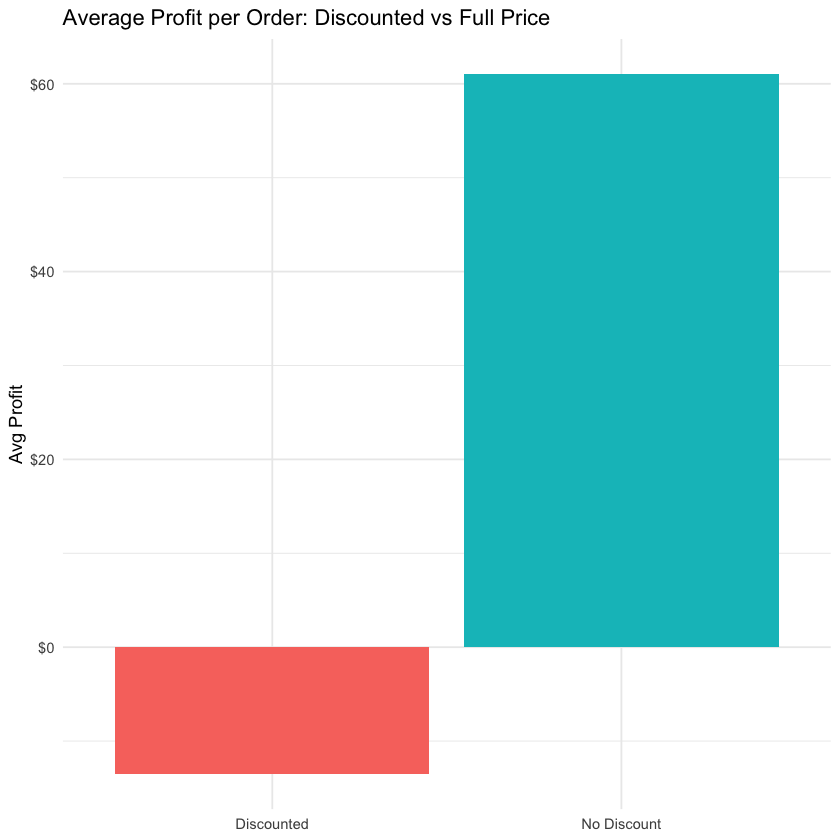

In [17]:
orders_with_returns |> 
    mutate(discount_flag = if_else(discount > 0, "Discounted", "No Discount")) |> 
    group_by(discount_flag) |> 
    summarise(avg_profit = mean(profit)) |> 
    ggplot(aes(discount_flag, avg_profit, fill = discount_flag)) + 
    geom_col() + 
    scale_y_continuous(labels = scales::dollar_format()) + 
    labs(
        title = "Average Profit per Order: Discounted vs Full Price", 
        x = NULL, 
        y = "Avg Profit"
    ) + 
    theme_minimal() + 
    theme(legend.position = "none")

### Profit per discount bucket

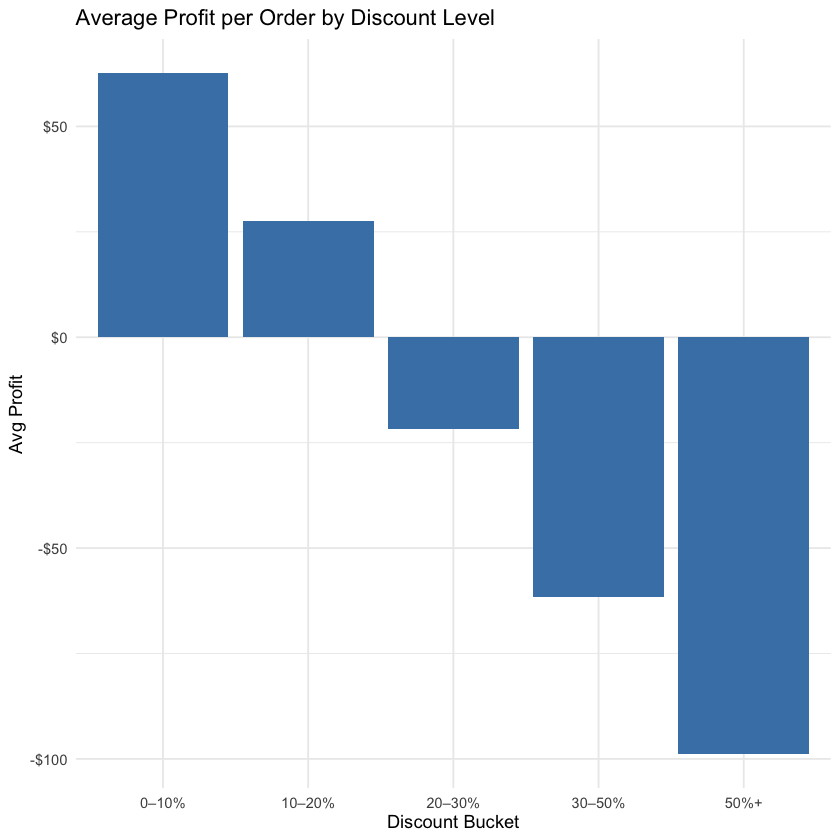

In [18]:
orders_with_returns |> 
    mutate(discount_bucket = cut(
        discount, 
        breaks = c(0, 0.1, 0.2, 0.3, 0.5, 1), 
        include.lowest = TRUE, 
        labels = c("0–10%", "10–20%", "20–30%", "30–50%", "50%+")
    )) |> 
    group_by(discount_bucket) |> 
    summarise(avg_profit = mean(profit)) |> 
    ggplot(aes(discount_bucket, avg_profit)) + 
    geom_col(fill = "steelblue") + 
    scale_y_continuous(labels = scales::dollar_format()) + 
    labs(
        title = "Average Profit per Order by Discount Level", 
        x = "Discount Bucket", 
        y = "Avg Profit"
    ) + 
    theme_minimal()

### Margin erosion due to discounts

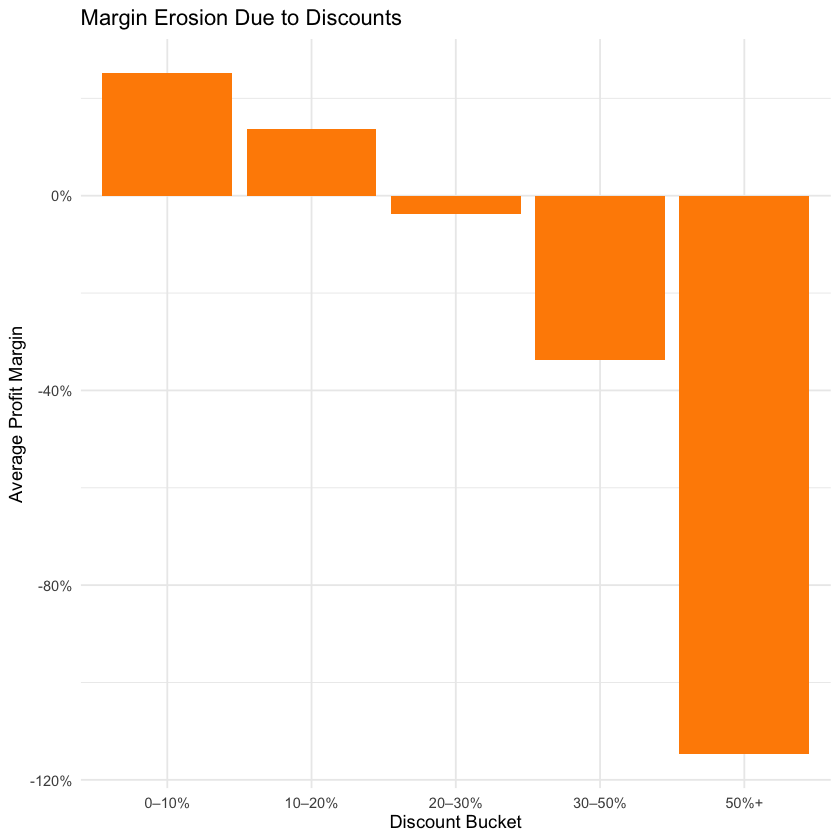

In [19]:
orders_with_returns |> 
    mutate(
        margin = profit / sales, 
        discount_bucket = cut(
            discount, 
            breaks = c(0, 0.1, 0.2, 0.3, 0.5, 1), 
            include.lowest = TRUE, 
            labels = c("0–10%", "10–20%", "20–30%", "30–50%", "50%+")
        )
    ) |> 
    group_by(discount_bucket) |> 
    summarise(avg_margin = mean(margin)) |> 
    ggplot(aes(discount_bucket, avg_margin)) + 
    geom_col(fill = "darkorange") + 
    scale_y_continuous(labels = scales::percent) + 
    labs(
        title = "Margin Erosion Due to Discounts", 
        x = "Discount Bucket", 
        y = "Average Profit Margin"
    ) + 
    theme_minimal()